In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.sparse.linalg as spla
import finite_lec as finite
import timesteppers_lec as timesteppers
import time
from IPython.display import display, clear_output

First we'll try to use Forward Euler to solve the diffusion equation
$$\partial_t u = \partial_x^2 u.$$
Recall that this equation has the solution
$$u \sim t^{-1/2}\exp(-x^2/(4t)).$$

/var/folders/88/6pmmpt1j1yl6ry0001r5f_lr0000gn/T/ipykernel_33939/3958636382.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


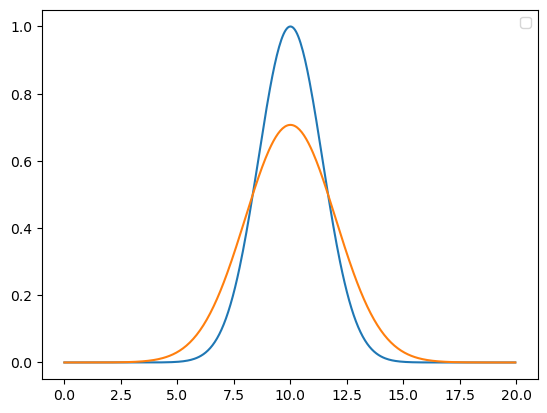

In [13]:
rest = 400 
grid = finite.UniformPeriodicGrid(rest,20)
x = grid.values
IC = np.exp(-(x-10)**2/4) # initial condition
target = 1/np.sqrt(2) * np.exp(-(x-10)**2/8)

plt.figure()
plt.plot(x,IC)
plt.plot(x, target)
plt.legend()
plt.show()

In [7]:
IC[0]

1.3887943864964021e-11

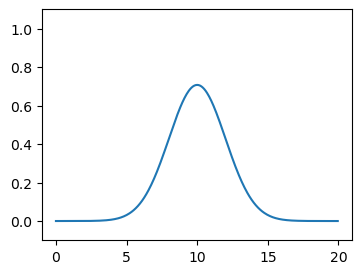

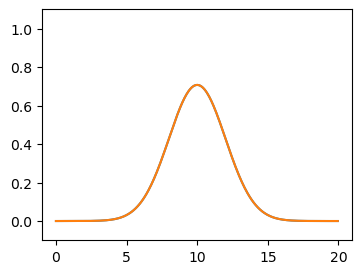

In [4]:
rest = 400 
grid = finite.UniformPeriodicGrid(rest,20)
x = grid.values 
IC = np.exp(-(x-10)**2/4) # initial condition
target = 1/np.sqrt(2) * np.exp(-(x-10)**2/8)

# matrix second derivatives
d2 = finite.CenteredFiniteSecondDifference(grid)
# second derivatives of u
f = lambda u:d2 @ u

ts = timesteppers.ForwardEuler(IC, f)

# scale factor 
alpha = 0.2 
# time step size is with h
dt = alpha * grid.dx **2
output_cadence = 10

# 1 time units
fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, ts.u)
plt.ylim([-0.1, 1.1])
while ts.t < 1:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(ts.u)
        clear_output(wait=True)
        display(fig)
p.set_ydata(ts.u)
plt.plot(x, target)
plt.show()

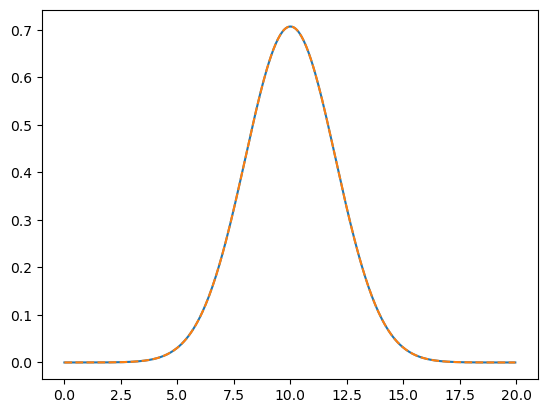

In [18]:
plt.figure()
plt.plot(x, ts.u)
plt.plot(x, target,'--')
plt.show()

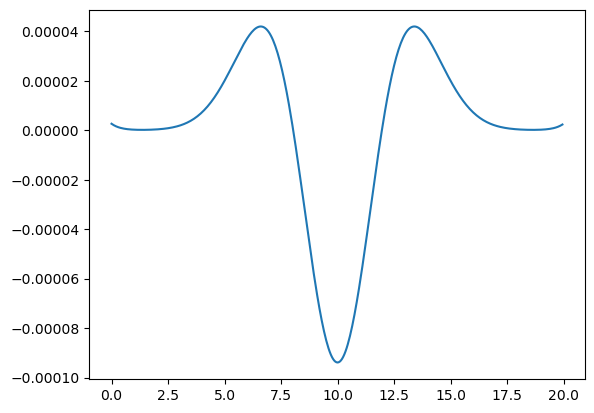

In [19]:
# error
plt.figure()
plt.plot(x, ts.u - target)
plt.show()

In [22]:
print(dt)
print(grid.dx) # h

0.0005000000000000001
0.05


## Backward Euler
(Linear, can use matrix )
The Backward Euler method is
$$u^{n} = u^{n-1} + \Delta t L(u^n).$$
We can think of this as
$$(I - \Delta t L)u^{n} = u^{n-1}.$$
We will solve for $u^{n}$ using a sparse matrix solve.

In [27]:
class ImplicitTimestepper(timesteppers.Timestepper):

    def __init__(self, u, L):
        super().__init__()
        self.u = u
        self.L = L
        N = len(u)
        self.I = sparse.eye(N, N) # idientiy matrix 

In [28]:
class BackwardEuler(ImplicitTimestepper):

    def _step(self, dt):
        # To save time, calculate current time step is same as past time step. 
        # if same, just use the last time step. if not, calculate the matrix
        if dt != self.dt:
            self.LHS = self.I - dt*self.L
        return spla.spsolve(self.LHS, self.u)
        # get solution without cal inverse 
        # return spla.spsolve(self.I - dt*self.L, self.u)
    

In [25]:
spla.spsolve?

Signature: spla.spsolve(A, b, permc_spec=None, use_umfpack=True)
Docstring:
Solve the sparse linear system Ax=b, where b may be a vector or a matrix.

Parameters
----------
A : ndarray or sparse matrix
    The square matrix A will be converted into CSC or CSR form
b : ndarray or sparse matrix
    The matrix or vector representing the right hand side of the equation.
    If a vector, b.shape must be (n,) or (n, 1).
permc_spec : str, optional
    How to permute the columns of the matrix for sparsity preservation.
    (default: 'COLAMD')

    - ``NATURAL``: natural ordering.
    - ``MMD_ATA``: minimum degree ordering on the structure of A^T A.
    - ``MMD_AT_PLUS_A``: minimum degree ordering on the structure of A^T+A.
    - ``COLAMD``: approximate minimum degree column ordering [1]_, [2]_.

use_umfpack : bool, optional
    if True (default) then use UMFPACK for the solution [3]_, [4]_, [5]_,
    [6]_ . This is only referenced if b is a vector and
    ``scikits.umfpack`` is installed.

Ret

We can use this to solve the diffusion equation
$$ \partial_t u = \partial_x^2 u,$$
using $L=\partial_x^2$.

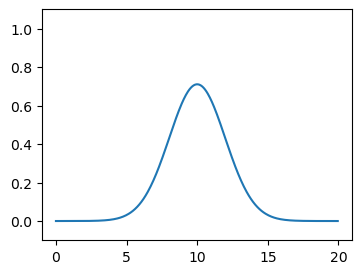

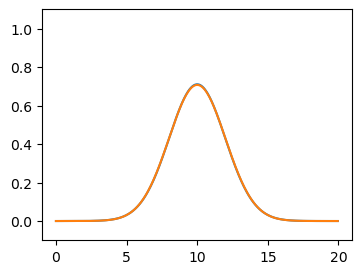

In [35]:
res = 400
grid = finite.UniformPeriodicGrid(res, 20)
x = grid.values
IC = np.exp(-(x-10)**2/4)
target = 1/np.sqrt(2)*np.exp(-(x-10)**2/8)

d2 = finite.CenteredFiniteSecondDifference(grid)

ts = BackwardEuler(IC, d2.matrix)
dt = grid.dx
print(dt)

output_cadence = 1
fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, ts.u)
plt.ylim([-0.1, 1.1])
while ts.t < 1:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(ts.u)
        clear_output(wait=True)
        display(fig)
        time.sleep(0.5)
p.set_ydata(ts.u)
plt.plot(x, target)
plt.show()

As well as the wave equation
$$ \partial_t u = \partial_x u,$$
using $L=\partial_x$.

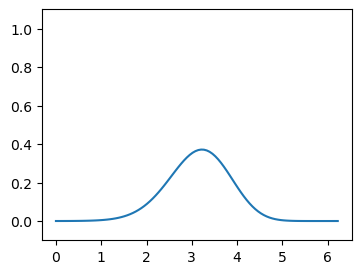

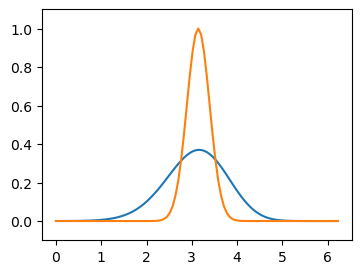

In [36]:
res = 100
grid = finite.UniformPeriodicGrid(res, 2*np.pi)
x = grid.values
IC = np.exp(-(x-np.pi)**2*8)
target = np.exp(-(x-np.pi)**2*8)

d = finite.CenteredFiniteDifference(grid)

ts = BackwardEuler(IC, d.matrix)

dt = grid.dx
print(dt)


output_cadence = 10
fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, ts.u)
plt.ylim([-0.1, 1.1])
while ts.t < 2*np.pi:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(ts.u)
        clear_output(wait=True)
        display(fig)
        time.sleep(0.2)
p.set_ydata(ts.u)
plt.plot(x, target)
plt.show()

How does the matrix solve work? One way is using the LU factorization. We are trying to solve
$$ A\cdot x = b$$
for $x$. We can write
$$ A = L \cdot U$$
where $L$ is a lower-triangular matrix, and $U$ is an upper-triangular matrix.

In [ ]:
def plot_2D(matrix):
    lim_margin = -0.05
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    I, J = matrix.shape
    matrix_mag = np.log10(np.abs(matrix))
    ax.pcolor(matrix_mag[::-1])
    ax.set_xlim(-lim_margin, I+lim_margin)
    ax.set_ylim(-lim_margin, J+lim_margin)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', 'box')
    plt.tight_layout()

Once doing this factorization, we solve
$$ U \cdot y = b$$
and then
$$ L \cdot x = y.$$